## Finding Jellyfish Galaxies in EAGLE

In [1]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sim_name = 'RefL0100N1504'
con = sql.connect("nkl161", password="FCGxrt20")

### Criteria:
* Subhalo mass > 1e10
* SFR > 1e-10
* 0.5 < r200 < 1.5

In [6]:
# Defining distance from central subhalo to target subhalo
# Subhalo coordinates
subx = 'sub.CentreOfPotential_x'  # in Mpc
suby = 'sub.CentreOfPotential_y'
subz = 'sub.CentreOfPotential_z'

# Group coordinates
groupx = 'fof.GroupCentreOfPotential_x'  # in Mpc
groupy = 'fof.GroupCentreOfPotential_y'
groupz = 'fof.GroupCentreOfPotential_z'

## Update 

1) I have removed the lower limit for R200 to include galaxies closer in because why not? This will also capture central galaxies, and that's ok. I will use central galaxies as a control group when visually categorizing the images.
2) I have specified to only look for galaxies in snapshots 27 and 28

In [11]:
# Define SQL query
jellyfish_query = f"""
    SELECT
        sub.GalaxyID as galID,
        sub.SubGroupNumber as SubGroupNum,
        sub.MassType_Star as StellarMass,
        sub.StarFormationRate as SFR,
        sqrt(square({subx}-{groupx}) + square({suby}-{groupy}) + square({subz}-{groupz})) as Distance,
        fof.Group_R_Crit200 as R200,
        fof.Group_M_Crit200 as M200
    FROM
        {sim_name}_SubHalo as sub,
        {sim_name}_FOF as fof,
        {sim_name}_Aperture as ap
    WHERE
        sub.GroupID = fof.GroupID and
        ap.GalaxyID = sub.GalaxyID and
        ap.ApertureSize = 30 and
        sub.SnapNum >= 27 and
        sub.MassType_STAR > 1e10 and
        sub.StarFormationRate > 1e-10 and
        sqrt(square({subx}-{groupx}) + square({suby}-{groupy}) + square({subz}-{groupz})) < fof.Group_R_Crit200*1.5
"""

# Execute query
jellyData = sql.execute_query(con, jellyfish_query)
print(len(jellyData))

6306


The output is a dictionary. You can add the query output to an empty dictionary as above, specifying that it is taking the ith row. You can then call the ith entry and the specific label (e.g. dictionary[i]['mass']), but not the index (e.g. dictionary[i][0]).

In [12]:
print(jellyData)

[( 9440186, 19, 1.8263159e+10, 1.9530905 , 1.76667887, 1426.7043  , 3.4184480e+14)
 ( 9441221, 24, 2.0993698e+10, 0.74676234, 1.83835715, 1426.7043  , 3.4184480e+14)
 ( 9449133, 27, 2.8440377e+10, 0.6439933 , 1.21878258, 1426.7043  , 3.4184480e+14)
 ...
 (11591453,  0, 1.1632921e+10, 0.15299435, 0.        ,  149.99185 , 3.6039092e+11)
 (11907563,  0, 1.2396382e+10, 0.17424613, 0.        ,  140.62122 , 2.9697714e+11)
 (12575319,  0, 1.0574487e+10, 0.12023214, 0.        ,  121.913414, 1.9351501e+11)]


## Analysis

Looking at distribution of galaxies

In [13]:
# Assigning dictionary output to variables
galID = jellyData[:]['galID']
SubGroupNum = jellyData[:]['SubGroupNum']
StellarMass = jellyData[:]['StellarMass']
SFR = jellyData[:]['SFR']
distance = jellyData[:]['Distance']
R200 = jellyData[:]['R200']/1000
M200 = jellyData[:]['M200']

In [14]:
# How many centrals and how many satellites
count = 0
for i in range(len(jellyData)):
    if SubGroupNum[i] == 0:
        count += 1
        
print('How many central galaxies? ', count)
print('How many satellites? ', len(jellyData)-count)

How many central galaxies?  4403
How many satellites?  1903


In [26]:
# Get satellite distances
sat_IDs = []
sat_dist = []   # Satellite distances
sat_R200 = []   # Satellite distances in R200
for i in range(len(jellyData)):
    if SubGroupNum[i] != 0:
        sat_IDs.append(galID[i])
        sat_dist.append(distance[i])
        sat_R200.append(distance[i]/R200[i])

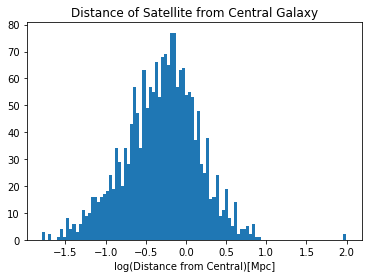

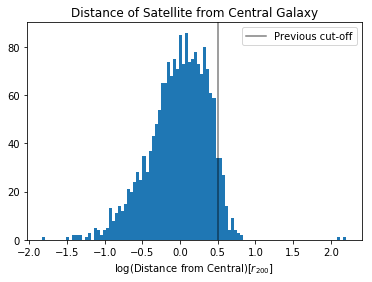

In [27]:
# Distance from center histogram -- see radius distribution
plt.hist(np.log10(sat_dist), bins=100)
plt.xlabel('log(Distance from Central)[Mpc]')
plt.title('Distance of Satellite from Central Galaxy')
plt.savefig('Satellite_DistanceMpc.png')
plt.show()
plt.close()

# Distance from center histogram -- in terms of R200
plt.hist(np.log10(sat_R200), bins=100)
plt.xlabel('log(Distance from Central)[$r_{200}$]')
plt.axvline(0.5, color='k', alpha=0.5, label='Previous cut-off')
plt.legend()
plt.title('Distance of Satellite from Central Galaxy')
plt.savefig('Satellite_DistanceR200.png')
plt.show()
plt.close()

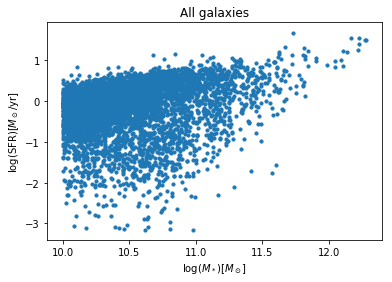

In [29]:
# Plot SFR vs Stellar mass to see distribution, color by central
plt.scatter(np.log10(StellarMass), np.log10(SFR), s=10)
plt.xlabel('log($M_*$)[$M_\odot$]')
plt.ylabel('log(SFR)[$M_\odot$/yr]')
plt.title('All galaxies')
plt.show()

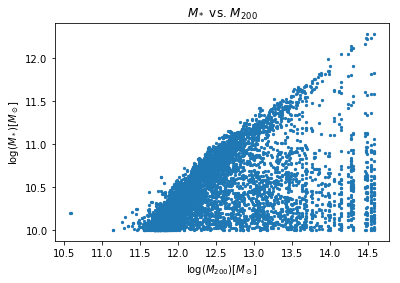

In [42]:
plt.scatter(np.log10(M200), np.log10(StellarMass), s=5)
# plt.plot(np.log10(x), np.log10(y), c='0', alpha=50)
plt.xlabel('log($M_{200}$)[$M_\odot$]')
plt.ylabel('log($M_*$)[$M_\odot$]')
plt.title('$M_*$ vs. $M_{200}$')
plt.savefig('MStar_M200.png')
plt.show()